# <center>CITS5508 Lab sheet 3</center>

**Name: Alastair Mory**<br>
**Student number:** 21120848<br>
**Date created:** March 27th 2019<br>
**Last modified:** April 3rd 2019<br>

### Table of Contents
1. [E. Coli Classification](#1)<br>
    1.1 [Data Overview](#1.2)<br>
    1.2 [Feature Selection and Cleaning](#1.2)<br>
    1.3 [Classification and Testing](#1.3)<br>
    1.4 [Results Comparision](#1.4)<br>    
2. [Perth Daily Solar Exposure and Max Temp](#2)<br>
    2.1 

In [23]:
from typing import (
    Any,
    Dict,
    List,
    Tuple,
    Union
)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    exceptions,
    linear_model,
    metrics,
    model_selection,
    preprocessing,
    svm,
    tree,
    warnings
)

Array2D = Union[List[List], np.ndarray, pd.DataFrame]
Array1D = Union[List, pd.core.series.Series]

## <a name="1"></a>1. E. Coli Classification
Decision tree and support vector machine classifiers will be compared on a classification task involving cellular localisation site of proteins from E. coli bacteria. The data set was obtained [here](https://archive.ics.uci.edu/ml/datasets/ecoli). The data set file is unlabeled, however a data set [description file](https://archive.ics.uci.edu/ml/datasets/ecoli) lists both the attribute and class label information:


#### Attribute Information:

  1.  Sequence Name: Accession number for the SWISS-PROT database
  2.  mcg: McGeoch's method for signal sequence recognition.
  3.  gvh: von Heijne's method for signal sequence recognition.
  4.  lip: von Heijne's Signal Peptidase II consensus sequence score.
       Binary attribute.
  5.  chg: Presence of charge on N-terminus of predicted lipoproteins.
	   Binary attribute.
  6.  aac: score of discriminant analysis of the amino acid content of
	   outer membrane and periplasmic proteins.
  7. alm1: score of the ALOM membrane spanning region prediction program.
  8. alm2: score of ALOM program after excluding putative cleavable signal
	   regions from the sequence.
       

#### Class Distribution (the class is the localisation site):

      cp  (cytoplasm)                                    143
      im  (inner membrane without signal sequence)        77               
      pp  (perisplasm)                                    52
      imU (inner membrane, uncleavable signal sequence)   35
      om  (outer membrane)                                20
      omL (outer membrane lipoprotein)                     5
      imL (inner membrane lipoprotein)                     2
      imS (inner membrane, cleavable signal sequence)      2


## <a name="1.1"></a>1.1 Data Overview

In [32]:
# Use the names given to the attriubtes above for column headers.
HEADER = ['Sequence Name', 'mcg', 'gvh', 'lip',
          'chg', 'aac', 'alm1', 'alm2', 'class']

data_file = pd.read_csv('./ecoli.data', delim_whitespace=True, names=HEADER)

# Immediately split our data to avoid a data snooping bias.
train, test = model_selection.train_test_split(data_file,
                                               test_size=0.2,
                                               train_size=0.8)
train = train.reset_index()
test = test.reset_index()


Below is a brief look at the training data set including some sample data instances, histograms and summary statistics of numeriv features.

From the sample data instances it's apparent one attribute is non-numeric, while the histogram shows all but two of the numeric attributes are roughly normally distributed. This is discussed further in section [1.2](#1.2).


In [29]:
"""Sample data instances"""
train.head()

index Sequence Name   mcg   gvh   lip  chg   aac  alm1  alm2 class
0    263    NMPC_ECOLI  0.67  0.84  0.48  0.5  0.74  0.54  0.37    om
1    157     DHG_ECOLI  0.84  0.44  0.48  0.5  0.48  0.71  0.74    im
2    293    DGAL_ECOLI  0.63  1.00  0.48  0.5  0.35  0.51  0.49    pp
3      8     APT_ECOLI  0.20  0.44  0.48  0.5  0.46  0.51  0.57    cp
4    300    FECR_ECOLI  0.32  0.39  0.48  0.5  0.53  0.28  0.38    pp

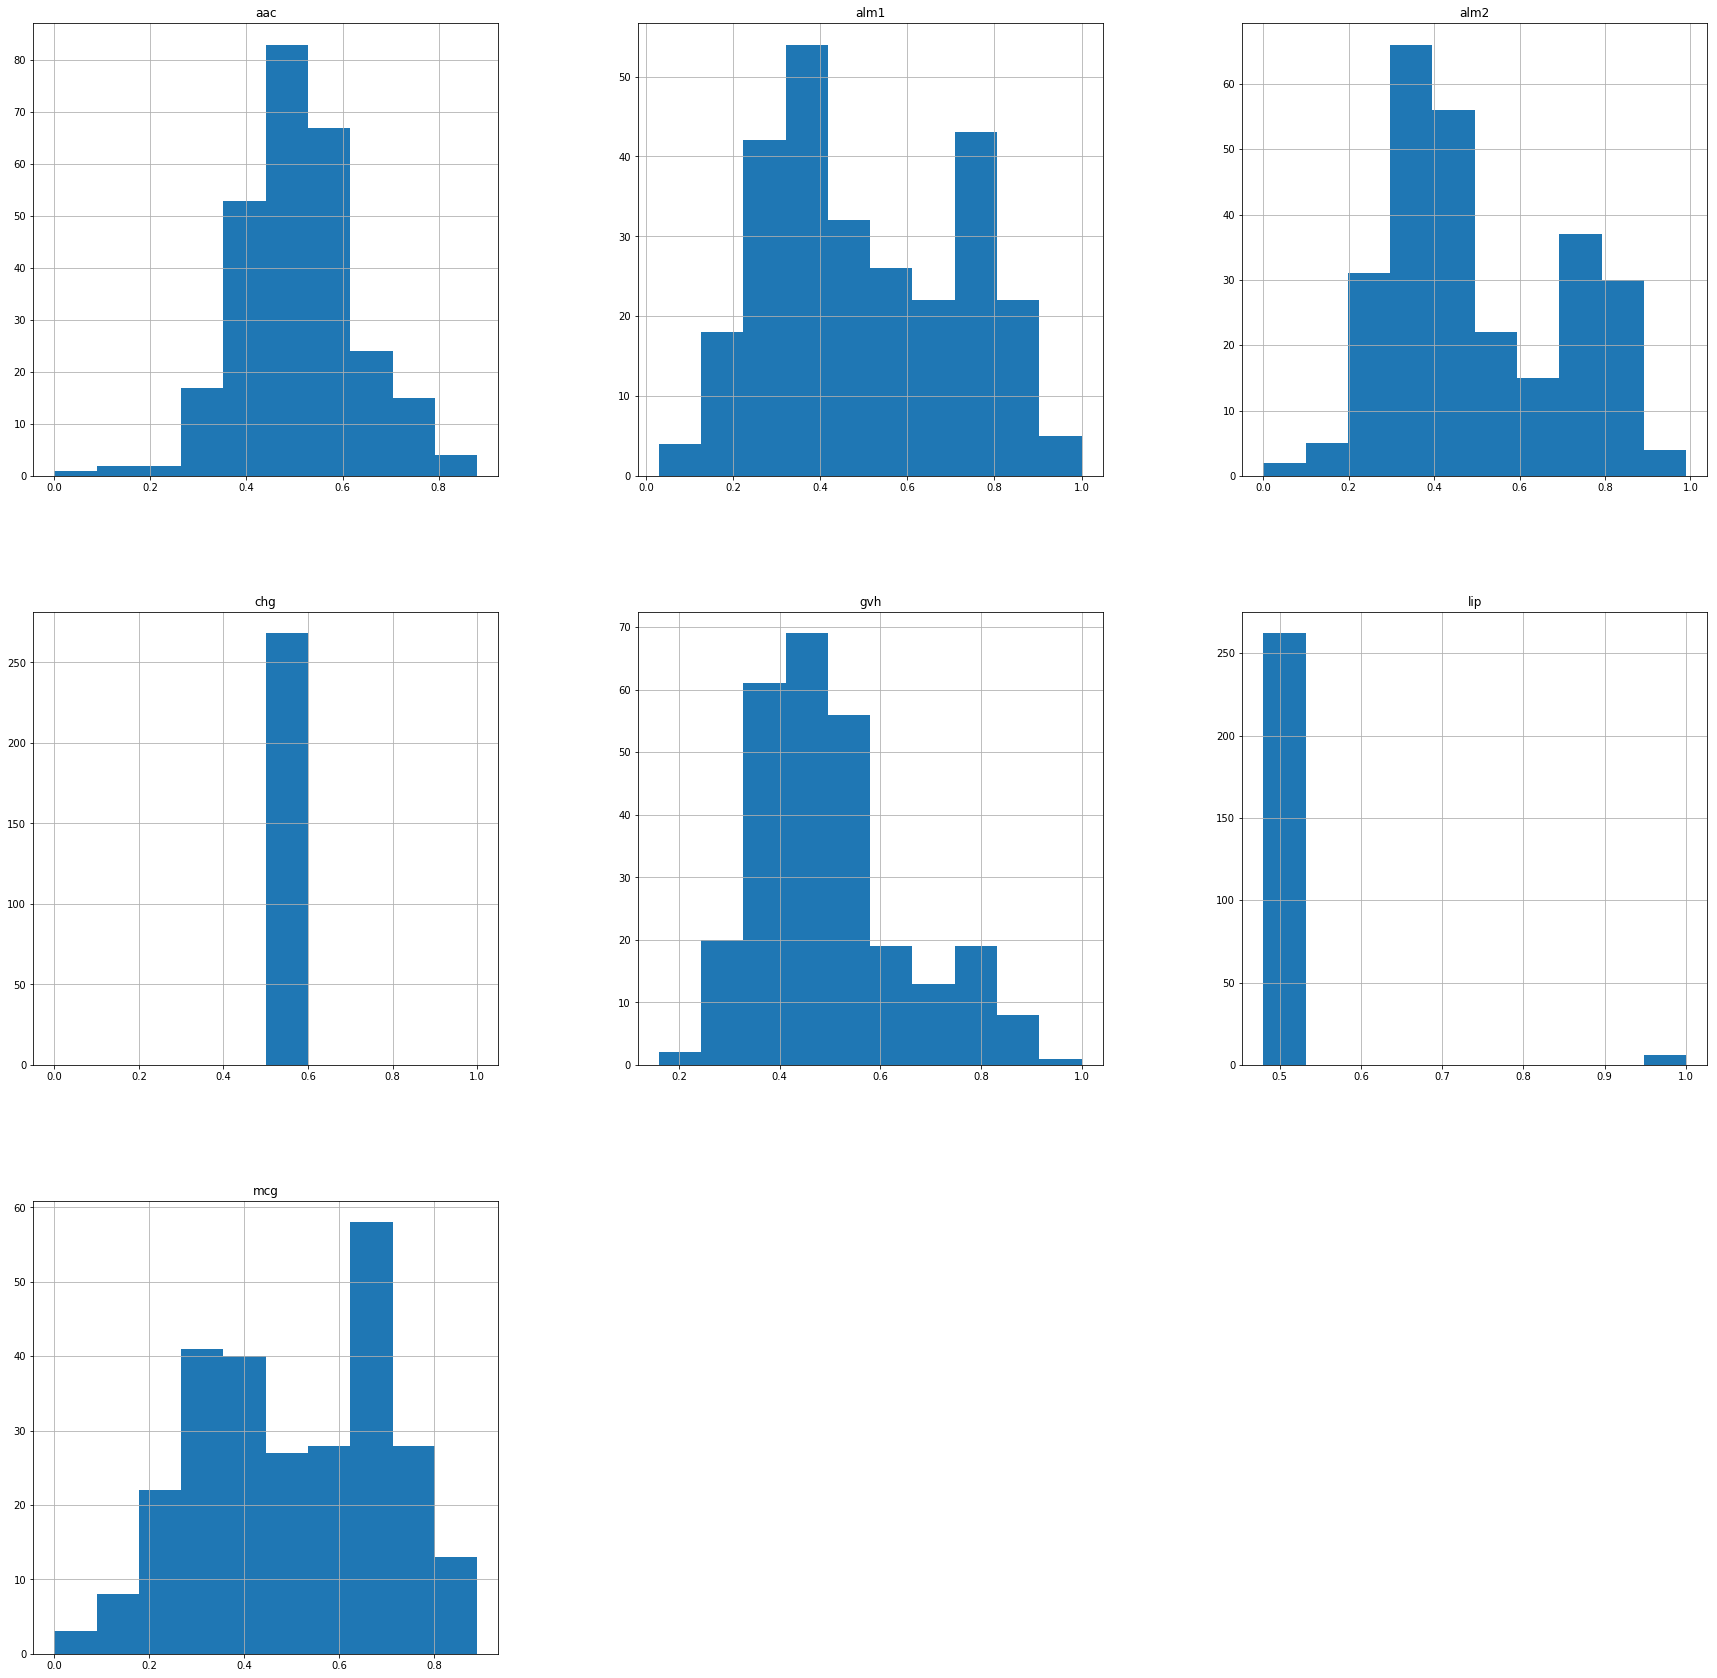

In [8]:
"""Histograms of numeric features."""
train.hist(column=HEADER[1:-1], layout=(3,3), figsize=(30,30))
plt.show()

In [9]:
"""Checking distributions of numerical features"""
train.describe()

index         mcg         gvh         lip    chg         aac  \
count  268.000000  268.000000  268.000000  268.000000  268.0  268.000000   
mean   167.578358    0.506493    0.499776    0.491642    0.5    0.505187   
std     95.150371    0.196226    0.151177    0.077074    0.0    0.121792   
min      0.000000    0.000000    0.160000    0.480000    0.5    0.000000   
25%     88.500000    0.340000    0.400000    0.480000    0.5    0.430000   
50%    168.500000    0.510000    0.470000    0.480000    0.5    0.500000   
75%    249.250000    0.670000    0.570000    0.480000    0.5    0.570000   
max    335.000000    0.890000    1.000000    1.000000    0.5    0.880000   

             alm1        alm2  
count  268.000000  268.000000  
mean     0.503619    0.503097  
std      0.219512    0.210963  
min      0.030000    0.000000  
25%      0.330000    0.350000  
50%      0.465000    0.430000  
75%      0.710000    0.712500  
max      1.000000    0.990000

## <a name="1.2"></a>1.2 Feature Selection and Cleaning


From above we can see Sequence Name is a string, it also looks like every row has a different unique string value so it won't be useful to the classifiers. Conversely the 'lip' and 'chg' features both appear to have almost all instances with only one value (0.48 & 0.5 respectively). 

In addition to removing some features from the data set there are three classes with less than 10 members ('omL', 'imL', 'imS') which will be removed.

Because it's important to preprocess both the training and test data in
exactly the same way, there's a function below that'll handle all this.

In [13]:
COLUMNS_TO_DROP = ['Sequence Name', 'chg', 'lip']
CLASSES_TO_DROP = ['omL', 'imL', 'imS']

print(f"Removing data instances with class: {CLASSES_TO_DROP}")
print(f"Removing data attributes: {COLUMNS_TO_DROP}")


def preprocess_data(data: pd.DataFrame,
                    drop_classes: List[str] = CLASSES_TO_DROP,
                    drop_columns: List[str] = COLUMNS_TO_DROP
                    ) -> Tuple[Array1D, Array2D]:
    """
    Drop rows containing data for classes in drop_classes and remove columns
    contained in drop_columns, returns the data's class labels (y) and the
    remaining data as x.
    """
    drop_rows = []
    for i in range(len(data)):
        if data.loc[i, 'class'] in drop_classes:
            drop_rows.append(i)
    data = data.drop(index=drop_rows)
    data.reset_index()
    y = data['class']
    if 'class' not in drop_columns:
        drop_columns.append('class')
    X = data.drop(columns=drop_columns)
    return y, X


train_y, train_X = preprocess_data(train)
test_y, test_X = preprocess_data(test)

Removing data instances with class: ['omL', 'imL', 'imS']
Removing data attributes: ['Sequence Name', 'lip', 'chg']


## <a name="1.3"></a>1.3 Classification and Testing


In [36]:
def test_classifier(clf: Any,  # Can be any SKLearn classifier object
                    train_X: Array2D, train_y: Array1D,
                    test_X: Array2D, test_y: Array1D,
                    normalise_data: bool = False,
                    f1_average_method: str = 'weighted'
                    ) -> Dict[str, Any]:
    """
    Fit clf against training data (train_X & train_y), run predictions on test
    data (test_X) and compare predictions to test_y, return confusion matrix
    of results.
    """
    if normalise_data:
        scaler = preprocessing.StandardScaler().fit(train_X)
        train_X = scaler.transform(train_X)
        test_X = scaler.transform(test_X)
    # Do the classification
    pred_y = clf.fit(train_X, train_y).predict(test_X)

    # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(test_y, pred_y)
    # Various Metrics
    accuracy = metrics.accuracy_score(test_y, pred_y)
    correct_count = metrics.accuracy_score(test_y, pred_y, normalize=False)
    error_count = len(test_y) - correct_count
    f1 = metrics.f1_score(test_y, pred_y, average=f1_average_method)

    results = {
        'y_true': test_y,
        'y_pred': pred_y,
        'confusion_matrix': confusion_matrix,
        'accuracy': accuracy,
        'f1': f1,
        'correct': correct_count,
        'errors': error_count
    }
    return results


SVM_clf = svm.SVC()

DT_clf = tree.DecisionTreeClassifier()

svm_unnorm_results = test_classifier(SVM_clf,
                                     train_X, train_y,
                                     test_X, test_y)

svm_norm_results = test_classifier(SVM_clf,
                                   train_X, train_y,
                                   test_X, test_y,
                                   normalise_data=True)

dt_results = test_classifier(DT_clf,
                             train_X, train_y,
                             test_X, test_y)


/home/alastair/Documents/ml/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## <a name="1.4"></a>1.4 Results Comparison


In [33]:
def print_result_metrics(svm, svm_norm, dt):
    results = [
        [svm['accuracy'], svm['f1'], svm['errors']],
        [svm_norm['accuracy'], svm_norm['f1'], svm_norm['errors']],
        [dt['accuracy'], dt['f1'], dt['errors']]
    ]
    rows = ['SVM, unnormalised', 'SVM, normalised', 'DT, unnormalised']
    columns = ['Accuracy', 'F1 Score', 'Error Count']
    results = pd.DataFrame(results, rows, columns)
    print(results)


print_result_metrics(svm_unnorm_results,
                     svm_norm_results,
                     dt_results)



                   Accuracy  F1 Score  Error Count
SVM, unnormalised  1.000000  1.000000            0
SVM, normalised    0.954545  0.950547            3
DT, unnormalised   1.000000  1.000000            0


In [34]:
"""
From:
Used under Scikit-Learn's BSD license terms.
"""
def plot_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyright (c) 2007–2019 The scikit-learn developers.
    """
    cm = confusion_matrix
    if not title:
        title = "Confusion Matrix"

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

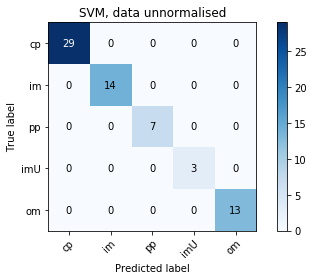

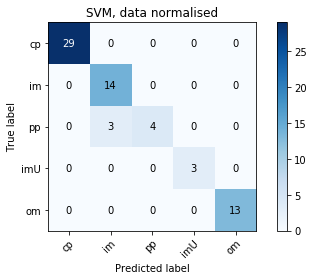

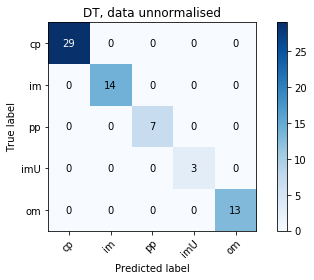

In [18]:
CLASS_LABELS = ['cp', 'im', 'pp', 'imU', 'om']

plot_confusion_matrix(svm_unnorm_results['confusion_matrix'], CLASS_LABELS,
                      title="SVM, data unnormalised")

plot_confusion_matrix(svm_norm_results['confusion_matrix'], CLASS_LABELS,
                      title="SVM, data normalised")

plot_confusion_matrix(svm_unnorm_results['confusion_matrix'], CLASS_LABELS,
                      title="DT, data unnormalised")

plt.show()

## <a name="2"></a>2 Perth Daily Solar Exposure and Max Temp



## <a name="2.1"></a>2 Data Overview

In [39]:
solar_data = pd.read_csv('SolarExposure_2018_Data.csv')
temp_data = pd.read_csv('Temperature_2018_Data.csv')

In [40]:
solar_data.head()

Product code  Bureau of Meteorology station number  Year  Month  Day  \
0   IDCJAC0016                                  9225  2018      1    1   
1   IDCJAC0016                                  9225  2018      1    2   
2   IDCJAC0016                                  9225  2018      1    3   
3   IDCJAC0016                                  9225  2018      1    4   
4   IDCJAC0016                                  9225  2018      1    5   

   Daily global solar exposure (MJ/m*m)  
0                                  31.8  
1                                  31.8  
2                                  31.7  
3                                  31.6  
4                                  24.8

In [41]:
temp_data.head()

Product code  Bureau of Meteorology station number  Year  Month  Day  \
0   IDCJAC0010                                  9225  2018      1    1   
1   IDCJAC0010                                  9225  2018      1    2   
2   IDCJAC0010                                  9225  2018      1    3   
3   IDCJAC0010                                  9225  2018      1    4   
4   IDCJAC0010                                  9225  2018      1    5   

   Maximum temperature (Degree C)  \
0                            34.0   
1                            37.7   
2                            29.8   
3                            30.9   
4                            26.1   

   Days of accumulation of maximum temperature Quality  
0                                            1       Y  
1                                            1       Y  
2                                            1       Y  
3                                            1       Y  
4                                            1       Y

In [50]:
solar = list(solar_data['Daily global solar exposure (MJ/m*m)'])
temp = list(temp_data['Maximum temperature (Degree C)'])
month = list(temp_data['Month'])
day = list(temp_data['Day'])


X_data = []
for i in range(len(solar)):
    X_data.append([solar[i], month[i], day[i]])

X = pd.DataFrame(X_data, columns = ['solar', 'month', 'day'])
y = pd.DataFrame(temp, columns = ['temp'])


train_X, test_X, train_y, test_y = model_selection.train_test_split(X,y, test_size=0.2)

In [19]:
DAYS_IN_MONTH = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


def get_day_of_year(month: int, day_of_month: int) -> int:
    day_of_year = sum(DAYS_IN_MONTH[:month - 1])
    day_of_year += day_of_month
    return day_of_year


def get_month_and_day(day_of_year: int) -> Tuple[int, int]:
    month = 1
    for i in range(12):
        if day_of_year > DAYS_IN_MONTH[i]:
            month += 1
            day_of_year -= DAYS_IN_MONTH[i]
        else:
            return (month, day_of_year)